In [94]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import pandas as pd
import glob
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import PIL
from PIL import ImageFile, Image

ImageFile.LOAD_TRUNCATED_IMAGES = True
import pathlib
from tqdm import tqdm

from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Model

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score
import warnings
warnings.filterwarnings("ignore")
from itertools import chain

import seaborn as sns

In [131]:
METRICS = [ 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.RootMeanSquaredError(name='root_mean_squared_error')
]

In [2]:
directory = '../data/cleaned_data'

## Balance classes

In [57]:
train_fog_filenames = glob.glob('../data/cleaned_data/fog_images/*')
train_smoke_filenames = glob.glob('../data/cleaned_data/smoke_images/*')
train_filenames = train_fog_filenames + train_smoke_filenames

In [58]:
train_labels = []
for filename in train_filenames:
    if "fog_images" in filename:
        train_labels.append("FOG")
    elif 'smoke_images' in filename:
        train_labels.append("SMOKE")

In [62]:
print(Counter(train_labels).keys() )# equals to list(set(words))
print(Counter(train_labels).values()) # counts the elements' frequency    
print(Counter(train_labels)['FOG'])
print(Counter(train_labels)['SMOKE'])

dict_keys(['FOG', 'SMOKE'])
dict_values([1608, 252])
1608
252


In [59]:
from collections import Counter

weight_for_0 = (1 / Counter(train_labels)['FOG'])*(len(train_labels))/2.0 
weight_for_1 = (1 / Counter(train_labels)['SMOKE'])*(len(train_labels))/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.58
Weight for class 1: 3.69


In [92]:
class_weight

{0: 0.5783582089552238, 1: 3.6904761904761902}

## Define Generators

In [3]:
batch_size = 16
img_height = 256
img_width = 256
epochs=50

In [98]:
X_train = image_dataset_from_directory(
    directory,
    labels='inferred',
    validation_split=0.2,
    subset="training",
    seed=1,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size)

X_test = image_dataset_from_directory(
    directory,
    labels='inferred',
    validation_split=0.2,
    subset="validation",
    seed=1,
    image_size=(img_height, img_width),
    batch_size=batch_size)

X_test2 = image_dataset_from_directory(
    directory,
    labels='inferred',
    validation_split=0.2,
    subset='validation',
    seed=2,
    image_size=(img_height, img_width),
    batch_size=1)

Found 1860 files belonging to 2 classes.
Using 1488 files for training.
Found 1860 files belonging to 2 classes.
Using 372 files for validation.
Found 1860 files belonging to 2 classes.
Using 372 files for validation.


In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
X_train = X_train.cache().repeat().shuffle(16).prefetch(buffer_size=AUTOTUNE)
X_test = X_test.cache().repeat().prefetch(buffer_size=AUTOTUNE)

## FUNCTIONS

In [6]:
def create_model(input_size):
    
    model = Sequential([
        layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_size),
        layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=input_size),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.Conv2D(16, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.5),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.5),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid', name='visualized_layer')
      ])
    return model

In [6]:
def transfer_model(input_size, weights = 'imagenet'):
        # note that the "top" is not included in the weights below
        base_model = Xception(weights=weights,
                          include_top=False,
                          input_shape=input_size)
        
        model = base_model.output
        
        # add new head
        model = GlobalAveragePooling2D()(model)
        predictions = Dense(1, activation='sigmoid', name='visualized_layer')(model)
        model = Model(inputs=base_model.input, outputs=predictions)

        return model

def change_trainable_layers(model, trainable_index):
    for layer in model.layers[:trainable_index]:
        layer.trainable = False
    for layer in model.layers[trainable_index:]:
        layer.trainable = True

## Model Eval Functions

In [110]:
def model_evaluate_val(ax, model, generator):

    for image, label in generator.take(1):
        prediction = model.predict(image)

        if (prediction < 0.5) != label:
            result = 'Correct'
        else:
            result = 'Incorrect'

        img = image[0].numpy().astype("uint8")
    
        label = 'Fog' if label==0 else 'Smoke'

    ax.imshow(img)
    ax.axis('off')
    ax.set_title('{}, Predicted {}'.format(label, result))
    return ax

def roc_curve(probabilities, labels):
    '''
    INPUT: numpy array, numpy array
    OUTPUT: array, array, array

    Take a numpy array of the predicted probabilities and a numpy array of the
    true labels.
    Return the True Positive Rates, False Positive Rates and Thresholds for the
    ROC curve.
    '''
    # tpr = tp / tp+fn
    # fpr = fp / fp+tn
    
    df = pd.DataFrame({'probabilities': probabilities, 'y': labels})
    df.sort_values('probabilities', inplace=True)

    actual_p = df.y.sum()
    actual_n = df.shape[0] - df.y.sum()
    
    df['tn'] = (df.y == 0).cumsum()
    df['fn'] = df.y.cumsum()
    df['fp'] = actual_n - df.tn
    df['tp'] = actual_p - df.fn
    
    df['fpr'] = df.fp/(df.fp + df.tn)
    df['tpr'] = df.tp/(df.tp + df.fn)
    df['precision'] = df.tp/(df.tp + df.fp)
    df['F1'] = 2*((df.tp/(df.tp + df.fp)) * (df.tp/(df.tp + df.fn)))/((df.tp/(df.tp + df.fp)) + (df.tp/(df.tp + df.fn)))
    df = df.reset_index(drop=True)
    return df

def plot_roc(ax, df):
    auc_ = round(auc(df.fpr, df.tpr),2)
    ax.plot([1]+list(df.fpr), [1]+list(df.tpr), label=f'AUC = {auc_}', color='r')
    ax.plot([0,1],[0,1], 'k', label="random")
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.set_title('ROC Curve')
    ax.legend()

In [200]:
def conf_matrix(ax, y_test_fog,y_test_smoke,label, tp=43, fp=5, fn=13, tn=311):

    cfn_matrix = np.array([[tn, fp],[fn, tp]])
    cfn_norm_matrix = np.array([[1.0 / y_test_fog,1.0/y_test_fog],[1.0/y_test_smoke,1.0/y_test_smoke]])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix

    sns.heatmap(norm_cfn_matrix,cmap='magma',linewidths=0.5,annot=True,ax=ax)

    ax.set_title('Confusion Matrix')
    ax.set_ylabel('Real Classes')
    ax.set_xlabel('Predicted Classes')
    fig.savefig('confusion_matrix' + label +  '.png')
    plt.show()

In [201]:
def print_model_properties(model, indices = 0):
    for i, layer in enumerate(model.layers[indices:]):
        print("Layer {} | Name: {} | Trainable: {}".format(i+indices, layer.name, layer.trainable))

## Start Working

In [89]:
#model = load_model('transfer_model.h5')

checkpoint_path = "cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [218]:
model.compile(loss='binary_crossentropy',
    optimizer='adam',
    metrics=METRICS)
print('- - -> Transfer Model compiled.')

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 save_best_only=True,
                                                 verbose=2)
mc = ModelCheckpoint('transfer_model.h5', save_best_only=True)
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(patience = 20 ,
                                                          monitor = "val_accuracy", 
                                                          mode="max",
                                                          verbose=2,
                                                          restore_best_weights=True)
print('- - - - -> Checkpoints defined.')

history = model.fit(
            X_train,
            steps_per_epoch=int(np.floor(1488/16)),
            epochs=50,
            class_weight=class_weight,
            callbacks=[cp_callback, mc, early_stopping_monitor],
            validation_data=X_test,
            validation_steps=np.floor(331/16))
print('- - -> Transfer Model trained.')

print(model.summary())

model.save('xception_50epoch.h5')

- - -> Transfer Model compiled.
- - - - -> Checkpoints defined.
Epoch 1/50
93/93 [==============================] - ETA: 0s - loss: 0.0252 - accuracy: 0.9906 - precision: 0.9333 - recall: 1.0000 - root_mean_squared_error: 0.0912
Epoch 00001: val_accuracy improved from -inf to 0.94687, saving model to cp.ckpt
93/93 [==============================] - 258s 3s/step - loss: 0.0252 - accuracy: 0.9906 - precision: 0.9333 - recall: 1.0000 - root_mean_squared_error: 0.0912 - val_loss: 0.2435 - val_accuracy: 0.9469 - val_precision: 0.9474 - val_recall: 0.7059 - val_root_mean_squared_error: 0.2221
Epoch 2/50
93/93 [==============================] - ETA: 0s - loss: 0.0413 - accuracy: 0.9872 - precision: 0.9234 - recall: 0.9847 - root_mean_squared_error: 0.1009
Epoch 00002: val_accuracy did not improve from 0.94687
93/93 [==============================] - 293s 3s/step - loss: 0.0413 - accuracy: 0.9872 - precision: 0.9234 - recall: 0.9847 - root_mean_squared_error: 0.1009 - val_loss: 0.4760 - val_ac

Epoch 17/50
93/93 [==============================] - ETA: 0s - loss: 0.0352 - accuracy: 0.9866 - precision: 0.9112 - recall: 0.9949 - root_mean_squared_error: 0.1067
Epoch 00017: val_accuracy did not improve from 0.95312
93/93 [==============================] - 273s 3s/step - loss: 0.0352 - accuracy: 0.9866 - precision: 0.9112 - recall: 0.9949 - root_mean_squared_error: 0.1067 - val_loss: 0.3034 - val_accuracy: 0.9438 - val_precision: 0.8947 - val_recall: 0.7083 - val_root_mean_squared_error: 0.2200
Epoch 18/50
93/93 [==============================] - ETA: 0s - loss: 0.0337 - accuracy: 0.9879 - precision: 0.9238 - recall: 0.9898 - root_mean_squared_error: 0.0992
Epoch 00018: val_accuracy did not improve from 0.95312
93/93 [==============================] - 281s 3s/step - loss: 0.0337 - accuracy: 0.9879 - precision: 0.9238 - recall: 0.9898 - root_mean_squared_error: 0.0992 - val_loss: 0.2239 - val_accuracy: 0.9500 - val_precision: 0.8696 - val_recall: 0.8000 - val_root_mean_squared_erro

In [65]:
#print_model_properties(model)

In [219]:
xception = load_model('xception_50epoch.h5')
#xception.load_weights(checkpoint_path)

In [69]:
print(X_test.class_names)

['fog_images', 'smoke_images']


In [103]:
preds = xception.predict(X_test)
preds_cls_idx = preds.argmax(axis=-1)
probs = preds.reshape(1,-1)
probabilities = list(chain.from_iterable(probs))

In [205]:
print(preds_cls_idx)
probabilities

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


[7.670833e-24,
 2.639867e-10,
 5.1810676e-09,
 1.1320424e-15,
 0.27128363,
 0.0011205375,
 0.9999925,
 2.1881137e-06,
 3.0566381e-18,
 5.8164407e-08,
 3.4264475e-14,
 7.443345e-15,
 3.012728e-08,
 1.1673657e-06,
 7.499347e-12,
 4.8804226e-15,
 1.0707375e-23,
 0.0014623404,
 9.292572e-08,
 5.349907e-13,
 1.4450444e-06,
 0.9999953,
 1.6664192e-06,
 3.728514e-22,
 7.303307e-07,
 0.00016441941,
 1.8043053e-15,
 0.06574163,
 4.4754812e-14,
 0.1780448,
 1.4953007e-06,
 1.6756557e-08,
 9.857141e-12,
 0.0023819506,
 5.3191144e-07,
 2.0706679e-07,
 4.6651746e-18,
 1.9531184e-05,
 3.7774635e-06,
 2.7273213e-09,
 0.00376907,
 1.4646612e-08,
 0.99983335,
 2.3251247e-21,
 2.9033214e-18,
 2.2090727e-21,
 6.083422e-14,
 3.6604777e-12,
 2.2153332e-22,
 0.99999976,
 1.2970616e-15,
 0.00078362226,
 2.007592e-05,
 6.48882e-08,
 2.7352877e-12,
 0.0001450479,
 1.6566629e-10,
 0.9987567,
 1.8003859e-06,
 6.766081e-12,
 3.7721143e-17,
 1.5068449e-13,
 0.9998322,
 4.5093015e-10,
 6.2115717e-19,
 0.0,
 0.21503

In [139]:
y = np.concatenate([y for x, y in X_test])

In [204]:
y

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,

In [126]:
xception.evaluate(X_test)

24/24 [==============================] - 29s 1s/step - loss: 0.1987 - tp: 43.0000 - fp: 5.0000 - tn: 311.0000 - fn: 13.0000 - accuracy: 0.9516 - precision: 0.8958 - recall: 0.7679 - auc: 0.9438


[0.1987217664718628,
 43.0,
 5.0,
 311.0,
 13.0,
 0.9516128897666931,
 0.8958333134651184,
 0.7678571343421936,
 0.9438290596008301]

In [198]:
tp, fp, fn, tn = 43, 5, 13, 311
cfn_matrix = np.array([[tn, fp],[fn, tp]])
cfn_norm_matrix = np.array([[1.0 / y_test_fog,1.0/y_test_fog],[1.0/y_test_smoke,1.0/y_test_smoke]])
norm_cfn_matrix = cfn_matrix * cfn_norm_matrix

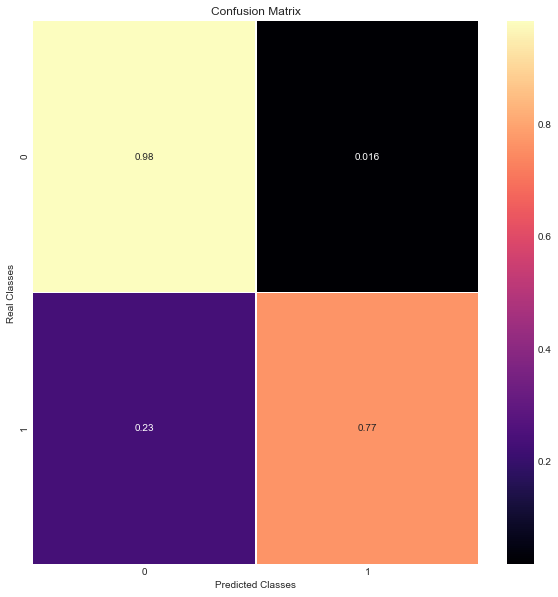

In [202]:
y_test_fog , y_test_smoke  = np.bincount(y)

fig, ax = plt.subplots(figsize=(10,10))
conf_matrix(ax, y_test_fog, y_test_smoke, label='smoke classification')

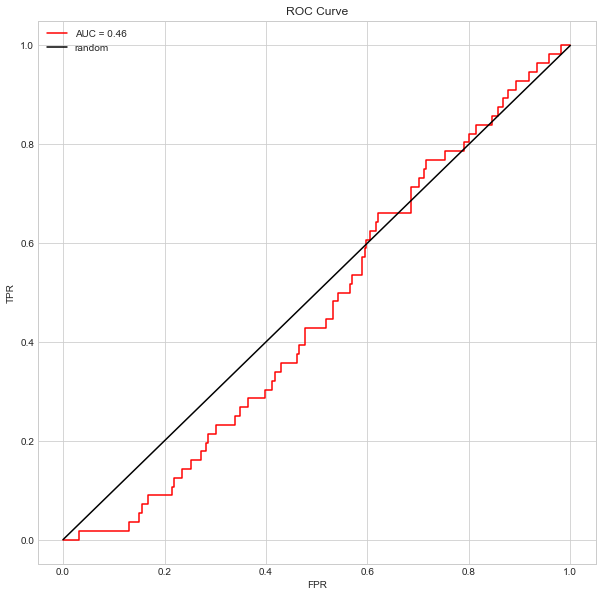

In [206]:
# ROC CURVE
fig, ax = plt.subplots(figsize=(10,10))
df = roc_curve(probabilities, y)
plot_roc(ax, df)
fig.show()
fig.savefig('transfermodel_roccurve.jpeg')

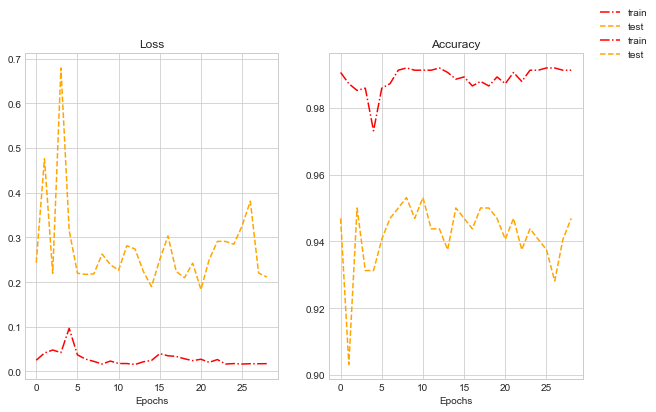

In [220]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].plot(history.history['loss'], label='train', linestyle='-.', color='red')
ax[0].plot(history.history['val_loss'], label='test', linestyle='--', color='orange')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[1].plot(history.history['accuracy'], label='train', linestyle='-.', color='red')
ax[1].plot(history.history['val_accuracy'], label='test',linestyle='--', color='orange')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
fig.legend()
fig.savefig('xception_loss_acc.jpeg')

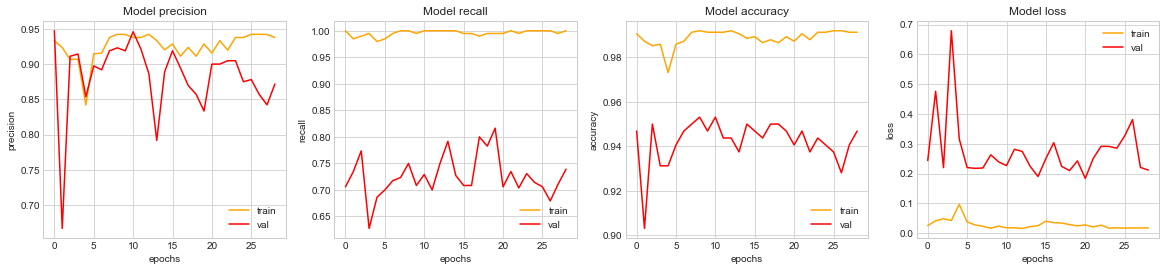

In [223]:
fig, ax = plt.subplots(1, 4, figsize=(20,4))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met], color='orange')
    ax[i].plot(history.history['val_' + met], color='red')
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.savefig("xception_metrics1.png")    

## Look at one image

In [216]:
#randomly sample an image from the test set and predict it's label
path=[train_filenames[i] for i in np.random.randint(len(train_filenames), size=1)][0]
print(path)
# Loads an image into PIL format.
tf.keras.preprocessing.image.load_img(
    path, grayscale=False, color_mode="rgb", target_size=None, interpolation="bilinear")

image = tf.keras.preprocessing.image.load_img(path, interpolation="bilinear")
input_arr = keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
prediction = xception.predict(input_arr,batch_size=batch_size)
label =["FOG" if "fog_images" in path else "SMOKE"]
predicted_label =["SMOKE" if prediction > 0.5 else "FOG"]
print("True label  {n} : predicted probability {s}: predicted label {l}".format(n=label[0], s=prediction[0][0],l=predicted_label[0]))  

../data/cleaned_data/fog_images/2019-05-15_1.jpg
True label  FOG : predicted probability 1.1740779182201067e-10: predicted label FOG


Populating the interactive namespace from numpy and matplotlib


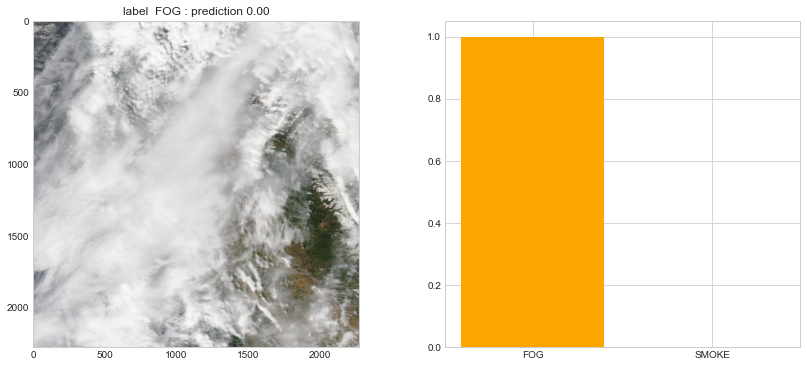

In [217]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread(path)

fig.subplots_adjust(hspace = .5, wspace=.001)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), facecolor='w', edgecolor='k')

ax1.imshow(mpimg.imread(path))
ax1.set_title("label  {} : prediction {:0.2f}".format(label[0], prediction[0][0] ))
ax1.grid(False)
ax2.bar([0,1],[1-prediction[0][0],prediction[0][0]], color='orange')

plt.xticks([0,1], ('FOG', 'SMOKE'))
plt.plot()
plt.show()
fig.savefig("one_xception_prediction4.png") 

## combine models in functional_api.ipynb

In [ ]:
image_input = keras.Input(
    shape=(img_height, img_width, 3), 
    name="satellite_image"
    )  # Variable-length sequence of ints
conditions_input = keras.Input(
    shape=(None,), 
    name="conditions")  # Variable-length sequence of ints
date_input = keras.Input(
    shape=(None,), 
    name="date") # Variable-length sequence of ints

xception_model=load_model('transfer_model_just_in_case.h5')(image_input)

xception = layers.model()(image_input)

x = layers.concatenate([title_features, body_features, tags_input])

# Outputs for both models will be probability for fire x 2
# possibly add xception probability to conditions_df
# add layer that concatenates probability to xgboost prediction probability
# add layer for one dense output
# gives a weight to xgboost probability
fire_risk = layers.Dense(1, name="fire")(x)

bigmodel = keras.Model(
    inputs = [image_input, conditions_input, date_input]
    outputs = fire_risk)